### Importing all necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Flatten, Reshape
from keras.models import Model
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

2023-10-22 13:59:56.022821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 13:59:56.022898: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 13:59:56.028889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 13:59:56.789454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Converting point cloud to binary voxel arrays

In [2]:
directory = "abc-dataset-ply/"
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path)
    dataset.append(binvox)

### Splitting dataset for training and testing

In [3]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:320]  # Adjust the number as needed
test_dataset = dataset[320:]   # The remaining data for testing

# Define the input shape
input_shape = (64, 64, 64, 1)

### Encoder

In [4]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(x)
# x = MaxPooling3D((2, 2, 2), padding='same')(x)
# x = Conv3D(4, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

2023-10-22 14:00:40.928386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 14:00:41.693244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 14:00:41.693930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Decoder

In [5]:
# x = Conv3D(4, (3, 3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Training autoencoder, prediction done on test dataset

In [9]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=20, batch_size=10, validation_data=(test_dataset, test_dataset))
reconstructed_data = autoencoder.predict(test_dataset)

Epoch 1/20
32/32 [==============================] - 12s 311ms/step - loss: 0.2914 - val_loss: 0.2186
Epoch 2/20
32/32 [==============================] - 10s 300ms/step - loss: 0.2914 - val_loss: 0.2186
Epoch 3/20
32/32 [==============================] - 10s 300ms/step - loss: 0.2914 - val_loss: 0.2186
Epoch 4/20
32/32 [==============================] - 10s 301ms/step - loss: 0.2505 - val_loss: 0.0889
Epoch 5/20
32/32 [==============================] - 10s 302ms/step - loss: 0.0766 - val_loss: 0.0474
Epoch 6/20
32/32 [==============================] - 10s 302ms/step - loss: 0.0605 - val_loss: 0.0441
Epoch 7/20
32/32 [==============================] - 10s 302ms/step - loss: 0.0574 - val_loss: 0.0422
Epoch 8/20
32/32 [==============================] - 10s 302ms/step - loss: 0.0553 - val_loss: 0.0411
Epoch 9/20
32/32 [==============================] - 10s 302ms/step - loss: 0.0537 - val_loss: 0.0399
Epoch 10/20
32/32 [==============================] - 10s 301ms/step - loss: 0.0523 - val_lo

In [10]:
encoder_model = Model(input_data, encoded)
encoded_representation = encoder_model.predict(test_dataset)

3/3 [==============================] - 0s 82ms/step


### Sample reconstruction from test dataset

In [11]:
import matplotlib.pyplot as plt

index = 17

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

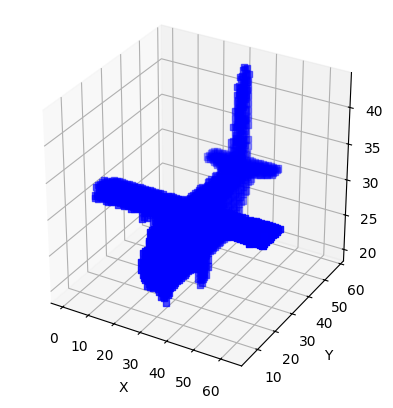

In [12]:
Visualization.matplotlib_visualize_original(original_sample)

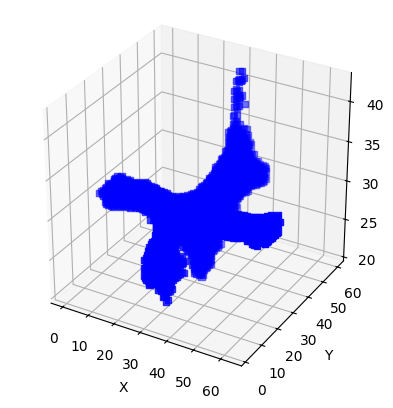

In [13]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [ ]:
Visualization.open3d_visualize_original(original_sample)

In [ ]:
Visualization.open3d_visualize_reconstructed(reconstructed_sample)